In [1]:
import BudykoSellers
import emulator_utils
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams.update({'font.size': 16})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",  # Use a LaTeX-compatible serif font
    "font.serif": ["Computer Modern Roman"],  # Or another LaTeX font
})

%load_ext autoreload
%autoreload 2

## Toy to test solving for heat capacity, feedback parameter, and diffusivity from data

#### Exp. 1: Uncoupled 3 box

In [153]:
out_Abrupt = BudykoSellers.Run_Budyko_Sellers(exp_flag=3)
T_Abrupt = out_Abrupt['T_ts']

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/chriswomack/anaconda3/envs/research/lib/python3.12/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/5v/9rw_h5d56d57jgsmbk2dfb980000gn/T/ipykernel_185/1008608681.py", line 1, in <module>
    out_Abrupt = BudykoSellers.Run_Budyko_Sellers(exp_flag=3)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py", line 345, in Run_Budyko_Sellers
    return SolverBudykoSellers(const, grid, params, init, time)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py", line 70, in SolverBudykoSellers
    NZ = stag_z.shape[1] - 1
         ~~~~~~~~~~~~^^^
IndexError: tuple index out of range

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users

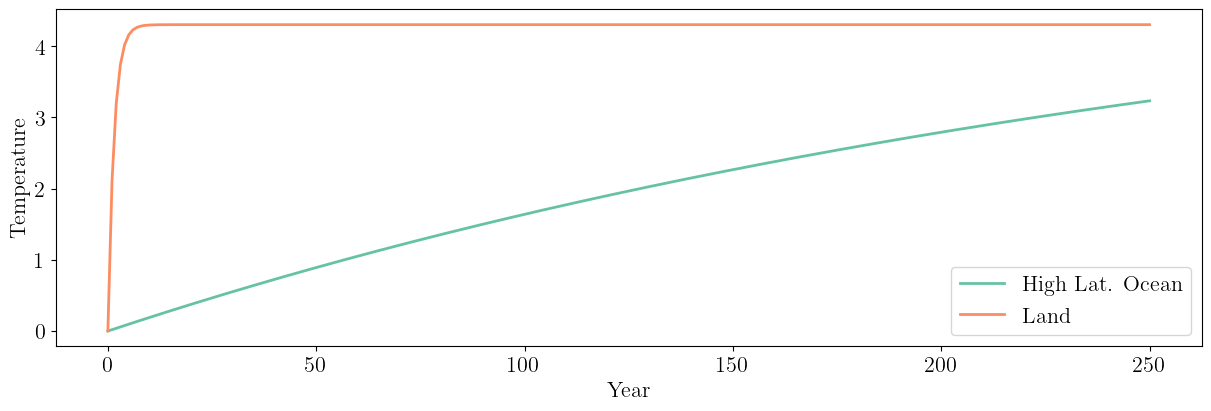

In [89]:
BudykoSellers.plot_BudykoSellers(out_Abrupt)

In [141]:
F = 3.7*np.ones((2,251))
A_DMD, B_DMD = emulator_utils.method_1a_DMD(np.squeeze(T_Abrupt), F)
C = np.divide(1,np.sum(B_DMD,axis=1))
lam = np.zeros(len(C))
for i in range(len(C)):
  lam[i] = -(A_DMD[i,i] - 1)*C[i]

3
(4, 250)


In [91]:
print(C, lam)

[190.69120692   1.7469568 ] [0.67035401 0.85999572]


#### Exp. 2: Coupled 3-box

In [92]:
out_Diff_Abrupt = BudykoSellers.Run_Budyko_Sellers(exp_flag=2)
T_Diff_Abrupt = out_Diff_Abrupt['T_ts']

100%|██████████| 365239/365239 [00:07<00:00, 51324.66it/s]
/Users/chriswomack/Documents/PhD/Project 1/BudykoSellers.py:268: UserWarning: Simulation has not reached equilibirum (diseq > 1e-3 W m-2)
  warnings.warn('Simulation has not reached equilibirum (diseq > 1e-3 W m-2)')


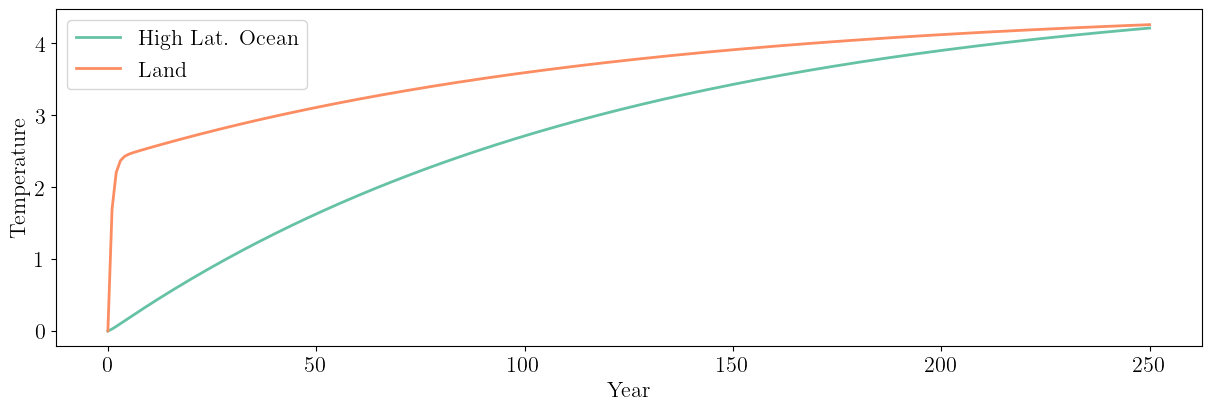

In [93]:
BudykoSellers.plot_BudykoSellers(out_Diff_Abrupt)

In [133]:
F = 3.7*np.ones((2,251))
A_DMD, B_DMD = emulator_utils.method_1a_DMD(np.squeeze(T_Diff_Abrupt), F)
C = np.divide(1,np.sum(B_DMD,axis=1))

3
(4, 250)


In [111]:
C

array([131.97875094,   2.18610256])

In [134]:
A_DMD

array([[0.98948929, 0.00498767],
       [0.30923284, 0.29755812]])

In [74]:
T_I = np.zeros((3,250))
F_I = np.zeros((3,250))
for i in range(1,250):
  T_I[:,i] = np.trapz(np.squeeze(T_Diff_Abrupt[0:3,:,0:i]))
  F_I[:,i] = np.trapz(F[:,0:i])

In [78]:
F_I.shape

(3, 250)

In [79]:
Omega = np.concatenate([np.squeeze(T_Diff_Abrupt[0:3,:,1:]),T_I])
L = F_I @ np.linalg.pinv(Omega)

A, B = L[:,:3], L[:,3:]

In [84]:
B

array([[ 18.67473727,  -1.08361696, -23.46534319],
       [ 18.67473727,  -1.08361696, -23.46534319],
       [ 18.67473727,  -1.08361696, -23.46534319]])

In [113]:
import numpy as np

def solve_structured_dmdc(X, F, Y):
    """
    Solve min || Y - A X - B F ||_F^2 
    subject to A = [[a, b], [b, d]] (i.e. off-diagonal entries equal).
    
    Parameters
    ----------
    X : ndarray of shape (2, m)
        Current-state snapshots.
    F : ndarray of shape (r, m)
        Input snapshots.
    Y : ndarray of shape (2, m)
        Next-state snapshots.

    Returns
    -------
    A : ndarray of shape (2, 2)
        Best-fit A with the given structure.
    B : ndarray of shape (2, r)
        Best-fit B.
    """

    # Dimensions
    d, m = X.shape    # d=2 in this example
    r, mF = F.shape
    assert m == mF, "X and F must have same number of columns"
    assert Y.shape == (d, m), "Y must be 2 x m"

    # We have 3 unknowns for A (a, b, d) plus 2*r unknowns for B => total 3 + 2r
    num_unknowns = 3 + 2*r

    # We'll build:
    #   M : (2*m) x (3 + 2*r)
    #   Y_vec : (2*m) x 1
    M = np.zeros((2*m, num_unknowns))
    Y_vec = np.zeros(2*m)

    # Fill M and Y_vec row by row
    # Row ordering: for each snapshot i, first row => y^{(i)}[0], second row => y^{(i)}[1]
    for i in range(m):
        x1 = X[0, i]  # x_n^(i)[0]
        x2 = X[1, i]  # x_n^(i)[1]
        f_i = F[:, i] # shape (r,)

        # Next-state is Y[:, i]
        y1 = Y[0, i] 
        y2 = Y[1, i]

        row1 = 2*i
        row2 = 2*i + 1

        # row1 corresponds to:  y1 = a*x1 + b*x2 + sum_k B[0,k] * f_i[k]
        # => coefficients for [a, b, d, B_{1,1..r}, B_{2,1..r}]
        M[row1, 0] = x1        # a
        M[row1, 1] = x2        # b
        M[row1, 2] = 0.0       # d
        # B_{1, k} multiplies f_i[k], so put those in the next r columns
        M[row1, 3 : 3+r] = f_i
        # B_{2, k} does not appear in row1, so zero out
        M[row1, 3+r : 3+2*r] = 0.0

        Y_vec[row1] = y1

        # row2 corresponds to:  y2 = b*x1 + d*x2 + sum_k B[1,k] * f_i[k]
        M[row2, 0] = 0.0       # a
        M[row2, 1] = x1        # b
        M[row2, 2] = x2        # d
        # B_{1,k} does not appear in row2:
        M[row2, 3 : 3+r] = 0.0
        # B_{2, k} multiplies f_i[k] in row2
        M[row2, 3+r : 3+2*r] = f_i

        Y_vec[row2] = y2

    print(np.linalg.matrix_rank(M))
    print(M.shape)

    # Solve the least-squares problem:  M * theta ~ Y_vec
    theta, residuals, rank, svals = np.linalg.lstsq(M, Y_vec, rcond=None)
    # theta is size (3 + 2*r,)

    # Parse out a, b, d
    a = theta[0]
    b = theta[1]
    d_ = theta[2]  # d is a Python builtin, so I'll name it d_

    # Parse out B => B[0,:] and B[1,:]
    B_row1 = theta[3 : 3+r]
    B_row2 = theta[3+r : 3+2*r]
    B_matrix = np.vstack([B_row1, B_row2])

    # Construct A
    A = np.array([[a, b],
                  [b, d_]])

    return A, B_matrix


X = np.squeeze(T_Diff_Abrupt[0:3,:,:-1])
Y = np.squeeze(T_Diff_Abrupt[0:3,:,1:])

# Solve
A_est, B_est = solve_structured_dmdc(X, F[:,:-1], Y)


5
(500, 7)


In [135]:
import numpy as np

def solve_structured_dmdc_offdiagA_diagB(X, F, Y):
    """
    Solve the constrained least-squares problem:
        min_{A,B} || Y - A X - B F ||_F^2
    subject to:
        A = [[a, b],
             [b, d]],
        B = [[p, 0],
             [0, q]].
    
    Parameters
    ----------
    X : ndarray of shape (2, m)
        Current-state snapshots (2D state).
    F : ndarray of shape (2, m)
        Input snapshots (2D input).
    Y : ndarray of shape (2, m)
        Next-state snapshots.
    
    Returns
    -------
    A : ndarray of shape (2, 2)
        Fitted A.
    B : ndarray of shape (2, 2)
        Fitted B.
    """
    # Basic dimension checks
    d, m = X.shape     # Here d=2
    r, mF = F.shape    # Here r=2
    assert m == mF, "X and F must have the same number of columns"
    assert Y.shape == (2, m), "Y must be 2 x m"

    # We have 5 unknowns: a, b, d, p, q
    num_unknowns = 5

    # We'll build a (2*m) x 5 matrix
    M = np.zeros((2*m, num_unknowns))
    y_vec = np.zeros(2*m)

    for i in range(m):
        x1, x2 = X[0, i], X[1, i]
        f1, f2 = F[0, i], F[1, i]
        y1, y2 = Y[0, i], Y[1, i]

        # row indices for snapshot i
        row1 = 2*i
        row2 = 2*i + 1

        # Equation 1: y1 = a*x1 + b*x2 + p*f1
        # Map to [a, b, d, p, q]
        # => a multiplies x1, b multiplies x2, d does not appear, p multiplies f1, q does not appear
        M[row1, 0] = x1    # a
        M[row1, 1] = x2    # b
        M[row1, 2] = 0.0   # d
        M[row1, 3] = f1    # p
        M[row1, 4] = 0.0   # q

        y_vec[row1] = y1

        # Equation 2: y2 = b*x1 + d*x2 + q*f2
        # => a does not appear, b multiplies x1, d multiplies x2, p does not appear, q multiplies f2
        M[row2, 0] = 0.0   # a
        M[row2, 1] = x1    # b
        M[row2, 2] = x2    # d
        M[row2, 3] = 0.0   # p
        M[row2, 4] = f2    # q

        y_vec[row2] = y2

    print(np.linalg.matrix_rank(M))
    print(M.shape)

    # Solve least squares: M * theta ~ y_vec
    theta, residuals, rank, svals = np.linalg.lstsq(M, y_vec, rcond=None)
    # theta = (a, b, d, p, q)

    # Reconstruct A, B
    a, b, d_ = theta[0], theta[1], theta[2]
    p, q_ = theta[3], theta[4]

    A = np.array([[a,   b],
                  [b,  d_]])
    B = np.array([[p,   0.],
                  [0.,  q_]])

    return A, B

X = np.squeeze(T_Abrupt[0:3,:,:-1])
Y = np.squeeze(T_Abrupt[0:3,:,1:])

# Solve
A_est, B_est = solve_structured_dmdc_offdiagA_diagB(X, F[:,:-1], Y)



5
(500, 5)


In [139]:
A_est

array([[ 9.96485065e-01, -3.82574151e-06],
       [-3.82574151e-06,  5.07717353e-01]])

In [142]:
A_DMD

array([[ 9.96484610e-01,  2.33885991e-06],
       [-4.52907466e-06,  5.07717808e-01]])